# Libraries.

In [1]:
# Essentials
import os
import pandas as pd
import numpy as np
import cv2

# Visualisations
import seaborn as sns
import matplotlib.pyplot as plt

# Pre-trained models.
from tensorflow.keras.applications import EfficientNetB0, InceptionV3

# Keras necessities.
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, GlobalAveragePooling2D, Flatten, Input, MaxPooling2D
from keras.models import Model
from keras.utils import to_categorical


# Metrics.
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tumor Class Object.

In [22]:
class TumorClassification():


  # Data Augmentation.
  def dataGeneration(self, imgsize):

    features, labels, test_X, test_y = [], [], [], []

    # Training images.
    ## Glioma
    pth = '/content/drive/MyDrive/Kaggle Competitions/Brain Tumor Classification/archive.zip (Unzipped Files)/Training/glioma_tumor/'
    for j in os.listdir(pth):
      img = cv2.imread(pth+'/'+j)
      img = cv2.resize(img, (imgsize, imgsize))

      features.append(img)
      labels.append(1)

    ## Meningioma
    pth = '/content/drive/MyDrive/Kaggle Competitions/Brain Tumor Classification/archive.zip (Unzipped Files)/Training/meningioma_tumor/'
    for j in os.listdir(pth):
      img = cv2.imread(pth+'/'+j)
      img = cv2.resize(img, (imgsize, imgsize))

      features.append(img)
      labels.append(2)

    ## Pituitary
    pth = '/content/drive/MyDrive/Kaggle Competitions/Brain Tumor Classification/archive.zip (Unzipped Files)/Training/pituitary_tumor/'
    for j in os.listdir(pth):
      img = cv2.imread(pth+'/'+j)
      img = cv2.resize(img, (imgsize, imgsize))

      features.append(img)
      labels.append(3)

    ## None
    pth = '/content/drive/MyDrive/Kaggle Competitions/Brain Tumor Classification/archive.zip (Unzipped Files)/Training/no_tumor/'
    for j in os.listdir(pth):
      img = cv2.imread(pth+'/'+j)
      img = cv2.resize(img, (imgsize, imgsize))

      features.append(img)
      labels.append(0)


    # Test Images.
    ## Glioma
    pth = '/content/drive/MyDrive/Kaggle Competitions/Brain Tumor Classification/archive.zip (Unzipped Files)/Testing/glioma_tumor/'
    for j in os.listdir(pth):
      img = cv2.imread(pth+'/'+j)
      img = cv2.resize(img, (imgsize, imgsize))

      test_X.append(img)
      test_y.append(1)

    ## Meningioma
    pth = '/content/drive/MyDrive/Kaggle Competitions/Brain Tumor Classification/archive.zip (Unzipped Files)/Testing/meningioma_tumor/'
    for j in os.listdir(pth):
      img = cv2.imread(pth+'/'+j)
      img = cv2.resize(img, (imgsize, imgsize))

      test_X.append(img)
      test_y.append(2)

    ## Pituitary
    pth = '/content/drive/MyDrive/Kaggle Competitions/Brain Tumor Classification/archive.zip (Unzipped Files)/Testing/pituitary_tumor/'
    for j in os.listdir(pth):
      img = cv2.imread(pth+'/'+j)
      img = cv2.resize(img, (imgsize, imgsize))

      test_X.append(img)
      test_y.append(3)

    ## None
    pth = '/content/drive/MyDrive/Kaggle Competitions/Brain Tumor Classification/archive.zip (Unzipped Files)/Testing/no_tumor/'
    for j in os.listdir(pth):
      img = cv2.imread(pth+'/'+j)
      img = cv2.resize(img, (imgsize, imgsize))

      test_X.append(img)
      test_y.append(0)
    
    # Conversion.
    ## Train
    features = np.array(features)
    features = features.reshape(-1, imgsize, imgsize, 3)

    ## Test
    test_X = np.array(test_X)
    test_X = test_X.reshape(-1, imgsize, imgsize, 3)

    ## Train
    labels = to_categorical(labels, num_classes = 4)
    
    ## Test
    test_y = np.array(test_y)
    test_y = to_categorical(test_y, num_classes = 4)
    
    # Train/Validation Split.
    train_X, val_X, train_y, val_y = train_test_split(features, labels, test_size = 0.1, shuffle = True, stratify = labels)

    return train_X, val_X, train_y, val_y, test_X, test_y




  # Pre-trained model.
  def knowledgeTransferModel(self, pre_model, include_top, input_shape):

    # EfficientNetB0 - Base layer.
    if pre_model == 'Efficient':
      EffNetB0 = EfficientNetB0(weights = 'imagenet', include_top = include_top, input_shape = input_shape)

      return EffNetB0

    # InceptionV3.
    elif pre_model == 'Inception':
      IncepV3 = InceptionV3(weights = 'imagenet', include_top = include_top, input_shape = input_shape)

      return IncepV3




  # Building the model.
  def buildModel(self, pre_model, pool, dropout, optimizer, loss, layers):

    model = pre_model.output

    # Choice of pooling layer.
    if pool == 'global': 
      model = GlobalAveragePooling2D()(model)

    else:
      model = MaxPooling2D()(model)

    # Dropout layer to prevent overfitting.
    model = Dropout(rate = dropout)(model)

    # Additional dense layers, if required.
    if layers[0] > 1:
      for i in range(layers[0]):
        model = Dense(layers[1], activation = 'relu')(model)

    # Output layer.
    model = Dense(4, activation = 'softmax')(model)
    model = Model(inputs = pre_model.input, outputs = model)

    # Choice of loss function, and optimizers.
    if loss == 'categorical':
      model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    elif loss == 'sparse':
      model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    return model




  # Defining callbacks.
  def callBacks(self, monitor, factor, patience, min_lr):

    tensorboard = TensorBoard(log_dir = '/content/drive/MyDrive/Kaggle Competitions/Brain Tumor Classification/archive.zip (Unzipped Files)')

    checkpoint = ModelCheckpoint('effnet.h5', monitor = monitor, save_best_only = True, mode = 'auto', verbose = 1)

    lr_reduction = ReduceLROnPlateau(monitor = monitor,
                                     factor = factor,
                                     patience = patience,
                                     min_lr = min_lr,
                                     mode = 'auto', verbose = 1)

    return tensorboard, checkpoint, lr_reduction




  # Visualising the model's performance during training.
  def historyPlots(self, history, metric):

    # Choice of metric to plot.
    if metric == 'accuracy':
      plt.plot(history.history['accuracy'], label = 'accuracy')
      plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
      plt.legend(loc = 'best')
      plt.xlabel('Epochs')
      plt.title('Training')
      plt.show()

    elif metric == 'loss':
      plt.plot(history.history['loss'], label = 'loss')
      plt.plot(history.history['val_loss'], label = 'val_loss')
      plt.legend(loc = 'best')
      plt.xlabel('Epochs')
      plt.title('Training')
      plt.show()




  # Plotting the confusion matrix.
  def confusionMatrix(self, model, X, Y):

    pred = model.predict(X)
    classes = np.argmax(pred, axis = 1)
    Y = np.argmax(Y, axis = 1)
    
    cmd = ConfusionMatrixDisplay(confusion_matrix(Y, classes), display_labels = ['None', 'Glioma', 'Meningioma', 'Pituitary'])
    cmd.plot()

In [4]:
# Important Variables
imgsize = 150
batch_size = 32
input_shape = (150, 150, 3)
target_size = (150, 150)

# Initialising the class object.
tc = TumorClassification()

# Retrieving the data sets.
train_X, val_X, train_y, val_y, test_X, test_y = tc.dataGeneration(imgsize)

# Defining the pre-model.
EffNetB0 = tc.knowledgeTransferModel('Efficient', include_top = False, input_shape = input_shape)

# Building the model.
model = tc.buildModel(pre_model = EffNetB0, pool = 'global', dropout = 0.5, optimizer = 'adam', loss = 'categorical', layers = [0, 0])

# Callbacks.
tensorboard, checkpoint, lr_reduction = tc.callBacks(monitor = 'val_accuracy', factor = 0.2, patience = 3, min_lr = 0.0005)

# Convolution Model.

In [5]:
history = model.fit(train_X, train_y, validation_data = [val_X, val_y], epochs = 12, batch_size = 32, callbacks = [tensorboard, checkpoint, lr_reduction])

Epoch 1/12
81/81 [==============================] - ETA: 0s - loss: 0.4199 - accuracy: 0.8459
Epoch 1: val_accuracy improved from -inf to 0.82578, saving model to effnet.h5
81/81 [==============================] - 29s 201ms/step - loss: 0.4199 - accuracy: 0.8459 - val_loss: 0.6136 - val_accuracy: 0.8258 - lr: 0.0010
Epoch 2/12
81/81 [==============================] - ETA: 0s - loss: 0.1639 - accuracy: 0.9427
Epoch 2: val_accuracy improved from 0.82578 to 0.92334, saving model to effnet.h5
81/81 [==============================] - 13s 159ms/step - loss: 0.1639 - accuracy: 0.9427 - val_loss: 0.2527 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 3/12
81/81 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.9721
Epoch 3: val_accuracy did not improve from 0.92334
81/81 [==============================] - 12s 152ms/step - loss: 0.0875 - accuracy: 0.9721 - val_loss: 0.4402 - val_accuracy: 0.8641 - lr: 0.0010
Epoch 4/12
81/81 [==============================] - ETA: 0s - loss: 0.0

In [6]:
model.save('brain_model.h5')

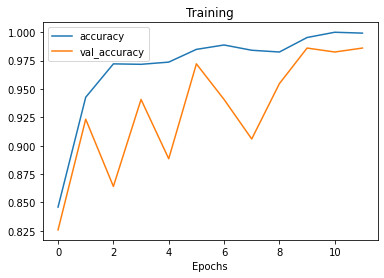

In [7]:
tc.historyPlots(history, 'accuracy')

## Evaluation

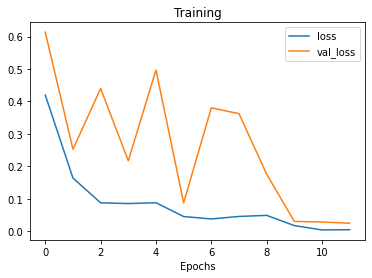

In [8]:
tc.historyPlots(history, 'loss')

# Predictions

## Training

81/81 [==============================] - 4s 30ms/step


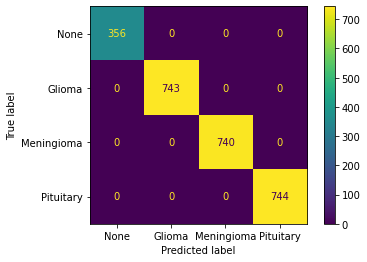

In [9]:
tc.confusionMatrix(model, train_X, train_y)

## Validation

9/9 [==============================] - 0s 30ms/step


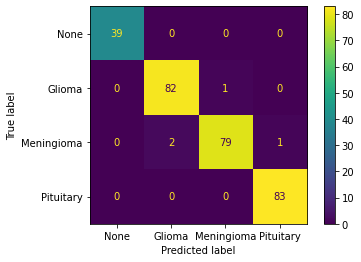

In [10]:
tc.confusionMatrix(model, val_X, val_y)

## Entire Test Set.

13/13 [==============================] - 1s 60ms/step


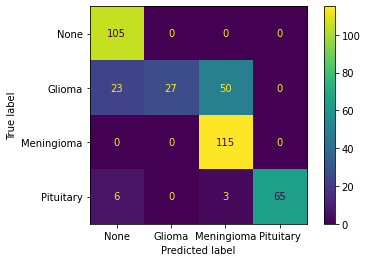

In [11]:
tc.confusionMatrix(model, test_X, test_y)

In [12]:
from sklearn.metrics import classification_report

In [13]:
pred = model.predict(test_X)
pred = np.argmax(pred, axis = 1)
test_Y = np.argmax(test_y, axis = 1)

13/13 [==============================] - 0s 29ms/step


In [14]:
print(classification_report(test_Y, pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       105
           1       1.00      0.27      0.43       100
           2       0.68      1.00      0.81       115
           3       1.00      0.88      0.94        74

    accuracy                           0.79       394
   macro avg       0.87      0.79      0.76       394
weighted avg       0.85      0.79      0.75       394



# Inception

In [32]:
# Defining the pre-model.
tc = TumorClassification()
IncepV3 = tc.knowledgeTransferModel('Inception', include_top = False, input_shape = input_shape)

# Building the model.
model2 = tc.buildModel(pre_model = IncepV3, pool = 'global', dropout = 0.5, optimizer = 'adam', loss = 'categorical', layers = [0, 0])

# Callbacks.
tensorboard, checkpoint, lr_reduction = tc.callBacks(monitor = 'val_accuracy', factor = 0.2, patience = 3, min_lr = 0.0005)

In [33]:
history2 = model2.fit(train_X, train_y, validation_data = [val_X, val_y], epochs = 20, batch_size = 32, callbacks = [tensorboard, checkpoint, lr_reduction])

Epoch 1/20
81/81 [==============================] - ETA: 0s - loss: 0.4879 - accuracy: 0.8200
Epoch 1: val_accuracy improved from -inf to 0.28223, saving model to effnet.h5
81/81 [==============================] - 18s 146ms/step - loss: 0.4879 - accuracy: 0.8200 - val_loss: 2.3617 - val_accuracy: 0.2822 - lr: 0.0010
Epoch 2/20
81/81 [==============================] - ETA: 0s - loss: 0.2694 - accuracy: 0.9106
Epoch 2: val_accuracy improved from 0.28223 to 0.65505, saving model to effnet.h5
81/81 [==============================] - 11s 131ms/step - loss: 0.2694 - accuracy: 0.9106 - val_loss: 1.3024 - val_accuracy: 0.6551 - lr: 0.0010
Epoch 3/20
81/81 [==============================] - ETA: 0s - loss: 0.1657 - accuracy: 0.9439
Epoch 3: val_accuracy improved from 0.65505 to 0.74216, saving model to effnet.h5
81/81 [==============================] - 11s 131ms/step - loss: 0.1657 - accuracy: 0.9439 - val_loss: 1.0978 - val_accuracy: 0.7422 - lr: 0.0010
Epoch 4/20
81/81 [======================

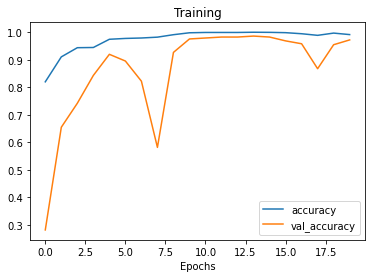

In [34]:
tc.historyPlots(history2, 'accuracy')

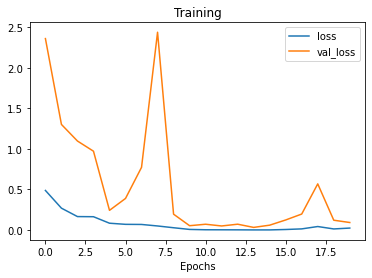

In [35]:
tc.historyPlots(history2, 'loss')

81/81 [==============================] - 4s 31ms/step


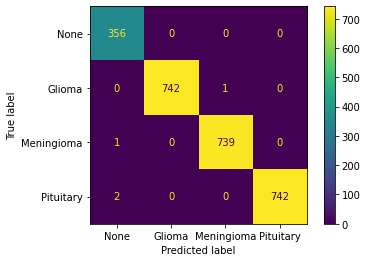

In [36]:
tc.confusionMatrix(model2, train_X, train_y)

9/9 [==============================] - 0s 29ms/step


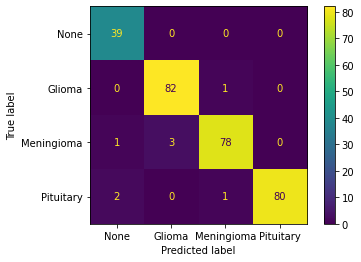

In [37]:
tc.confusionMatrix(model2, val_X, val_y)

13/13 [==============================] - 0s 30ms/step


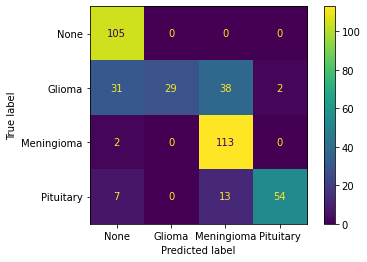

In [38]:
tc.confusionMatrix(model2, test_X, test_y)

In [39]:
pred = model2.predict(test_X)
pred = np.argmax(pred, axis = 1)
test_Y = np.argmax(test_y, axis = 1)
print(classification_report(test_Y, pred))

13/13 [==============================] - 0s 30ms/step
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       105
           1       1.00      0.29      0.45       100
           2       0.69      0.98      0.81       115
           3       0.96      0.73      0.83        74

    accuracy                           0.76       394
   macro avg       0.84      0.75      0.73       394
weighted avg       0.83      0.76      0.73       394

